In [1]:
! pip install -q scikit-plot

# **Import**

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import string

In [3]:
import sys
filePath = '/Users/pratiksayanekar/Documents/DL_20200161'
#filePath = '/content/drive/My Drive/DeepLearning'
sys.path.append(filePath)

In [4]:
from utils.basic_utilities import Utils
from models.LSTM_1 import LSTM_Model
from models.CNN_1 import CNN_Model
from models.Word2Vec_1 import Word2VecModel
from models.BiLSTM import BiLSTM_Model

/Users/pratiksayanekar/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
from sklearn.metrics import classification_report

# **Reading Preprocessed Data**

In [6]:
#df = pd.read_csv('/content/drive/MyDrive/DeepLearning/Data/preprocessed_data.csv')
df = pd.read_csv('{}/Data/preprocessed_data.csv'.format(filePath))
df.head()

,emotion,content,original_content,text
0,disappointed,oh fuck did i wrote fil grinningfacewithsweat nsorry spot disappointedface,b'RT @Davbingodav: @mcrackins Oh fuck.... did I wrote Fil ??? :grinning_face_with_sweat:\nSorry Spot. :disappointed_face:',rt oh fuck wrote fil grinning_face_with_sweatnsorry spot isappointed_face
1,disappointed,i feel nor am i shamed by it,i feel nor am i shamed by it,feel shamed
2,disappointed,i had been feeling a little bit defeated by the step of faith we would need to take to try to resolve our problem,i had been feeling a little bit defeated by the steps of faith we would need to take to try to resolve our problem,feeling little bit defeated steps faith need try resolve problem
3,happy,imagine if that reaction guy that called jj kfc saw this my man would ve started cry lmao,"b""@KSIOlajidebt imagine if that reaction guy that called JJ KFC saw this. my man would've started crying lmao """,imagine reaction guy called jj kfc saw man ve started crying lmao
4,disappointed,i wouldnt feel burdened so that i would live my life a a testament to his sacrifice that wa out of a love so pure and innocent yet so great and mighty,i wouldnt feel burdened so that i would live my life as a testament to his sacrifice that was out of a love so pure and innocent yet so great and mighty,wouldnt feel burdened live life testament sacrifice love pure innocent great mighty


In [7]:
df.text = df.text.astype(str)

# **Splitting dataset into train(80%) and test(20%)**

In [8]:
util = Utils()
X_train, X_test, y_train, y_test = util.split_data(df)
print("The shape of train data: ",X_train.shape)
print("The shape of train target: ",y_train.shape)
print("The shape of test data: ",X_test.shape)
print("The shape of test target: ",y_test.shape)

Initialization of Utilities...
The shape of train data:  (733260,)
The shape of train target:  (733260,)
The shape of test data:  (183315,)
The shape of test target:  (183315,)


In [9]:
y_test.value_counts()

disappointed    62743
happy           60374
angry           60198
Name: emotion, dtype: int64

# **Tokenization and Padding of each tweet**

In [10]:
max_len = util.max_len(df)
print("Maximum length of tweet:", max_len)

Maximum length of tweet: 122


In [11]:
train_converted, test_converted = util.tokenization_padding(X_train, X_test, max_len)
print("After Tokenization and Padding...")
print("The shape of train data: ", train_converted.shape)
print("The shape of test data: ", test_converted.shape)

After Tokenization and Padding...
The shape of train data:  (733260, 122)
The shape of test data:  (183315, 122)


In [12]:
target_converted_train, target_converted_test = util.one_hot_target_variable(y_train, y_test)
print("After one hot encoding of target variable...")
print("The shape of train target: ", target_converted_train.shape)
print("The shape of test target: ", target_converted_test.shape)

After one hot encoding of target variable...
The shape of train target:  (733260, 3)
The shape of test target:  (183315, 3)


# **Word2Vec Model**

In [13]:
word2vec = Word2VecModel()
# word2vec_model = word2vec.create_model(X_train)

# I have created a seperate class for word2vec model which has functions to create model and embedding matrix, 
# and it was working perfectly fine until I moved to local machine from colab.
# There was some version mismatch issue, 
# please refer, https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4
# so I have created below additional method which will return the word2vec model.

Word2Vec Model Initialization...


In [14]:
import numpy as np
from gensim.models import Word2Vec

def create_word2vec_model(X_train):
    # Creating Word2Vec training dataset.
    Word2vec_train_data = list(map(lambda x: x.split(), X_train))

    word2vec_model = Word2Vec(sentences = Word2vec_train_data, vector_size=max_len, min_count=5)

    print("Vocabulary Length:", len(word2vec_model.wv))
    return word2vec_model

In [15]:
word2vec_model = create_word2vec_model(X_train)

Vocabulary Length: 34749


In [16]:
train_converted, test_converted, tokenizer = util.tokenization_padding_oov_token(X_train, X_test, max_len)
print("After Tokenization and Padding...")
print("The shape of train data: ", train_converted.shape)
print("The shape of test data: ", test_converted.shape)

After Tokenization and Padding...
The shape of train data:  (733260, 122)
The shape of test data:  (183315, 122)


In [17]:
vocab_length = len(tokenizer.word_index) + 1
embedding_matrix = word2vec.create_embedding_matrix(vocab_length, tokenizer, word2vec_model, max_len)

Embedding Matrix Shape: (159426, 122)


# **Deep Learning Models**

In [18]:
EPOCH = 10
BATCH_SIZE = 2048 # 1024

# **CNN Model**

In [19]:
# Below method is commented as now for embedding layer some weight matrix is also provided as input.

# cnn = CNN_Model()
# model = cnn.create_model(embed_dim = 100, num_filters = 128, 
#                           input_len = train_converted.shape[1], feature = 200000, 
#                           drop_out = 0.5, num_words=4)
# model.summary()

In [20]:
cnn = CNN_Model()
model = cnn.create_model(embed_dim = max_len, num_filters = 128, 
                          input_len = train_converted.shape[1], feature = vocab_length, 
                          drop_out = 0.5, num_words=4, embedding_matrix = embedding_matrix)
model.summary()

CNN Model Initialization...
Model Created Successfully...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 122, 122)          19449972  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 122, 122)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 119, 128)          62592     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 19,512,951
Trainable params: 19,512,951
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(train_converted, target_converted_train, epochs = EPOCH, 
                    batch_size=BATCH_SIZE, validation_split=0.2,
                    callbacks=cnn.callbacks)

Epoch 1/10
287/287 [==============================] - 187s 652ms/step - loss: 0.6331 - acc: 0.7234 - val_loss: 0.2722 - val_acc: 0.8839

Epoch 00001: val_loss improved from inf to 0.27225, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN/assets
Epoch 2/10
287/287 [==============================] - 184s 640ms/step - loss: 0.3113 - acc: 0.8696 - val_loss: 0.2507 - val_acc: 0.8903

Epoch 00002: val_loss improved from 0.27225 to 0.25074, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN/assets
Epoch 3/10
287/287 [==============================] - 184s 642ms/step - loss: 0.2763 - acc: 0.8829 - val_loss: 0.2413 - val_acc: 0.8943

Epoch 00003: val_loss improved from 0.25074 to 0.24133, saving model to /Users/pratiksayanekar/Documents/DL_20200161/ch

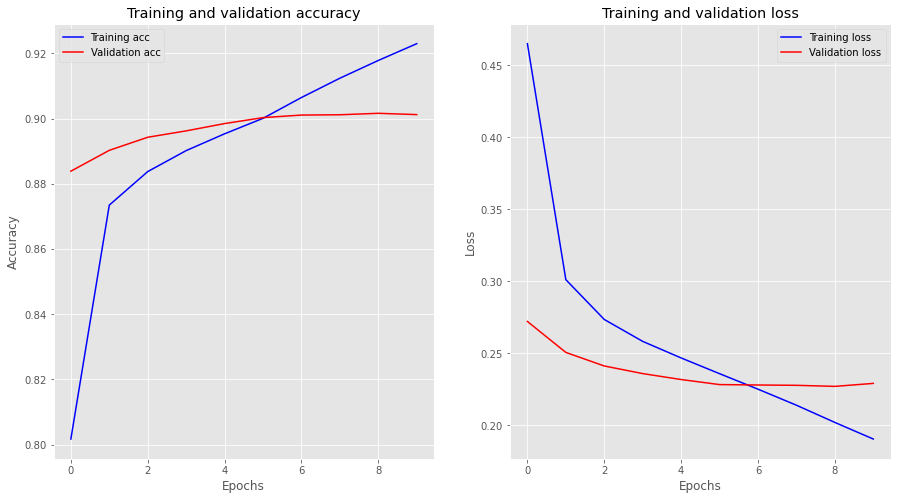

In [22]:
util.plot_accuracy_loss(history, 'CNN')

# **Evaluation**

In [23]:
model = cnn.load_saved_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 122, 122)          19449972  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 122, 122)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 119, 128)          62592     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 19,512,951
Trainable params: 19,512,951
Non-trainable params: 0
_________________________________________________________________


In [24]:
score, acc = model.evaluate(test_converted, target_converted_test, verbose = 2, batch_size = BATCH_SIZE)
print("The loss of this model: %.2f" % (score))
print("The accuracy of this model: %.2f" % (acc))

90/90 - 12s - loss: 0.2298 - acc: 0.9005
The loss of this model: 0.23
The accuracy of this model: 0.90


In [25]:
y_pred = model.predict(test_converted)

Confusion Matrix: 
 [[55139  8639  2638]
 [ 4614 53454  1245]
 [  445   650 56491]]


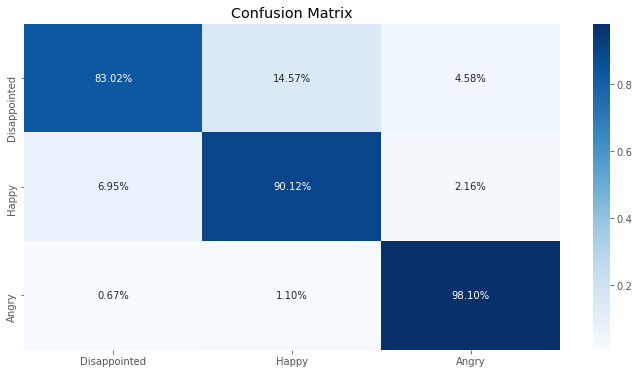

In [26]:
test,pred = util.plot_confusion_matrix(y_pred, target_converted_test, 'CNN')

In [27]:
print("Classification Report: ", classification_report(test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.92      0.83      0.87     66416
           1       0.85      0.90      0.88     59313
           2       0.94      0.98      0.96     57586

    accuracy                           0.90    183315
   macro avg       0.90      0.90      0.90    183315
weighted avg       0.90      0.90      0.90    183315



# **CNN_v2**

In [28]:
# Below method is commented as now for embedding layer some weight matrix is also provided as input.

# cnn = CNN_Model()
# model = cnn.create_model_v2(embed_dim = 100, num_filters = 128, 
#                           input_len = train_converted.shape[1], feature = 200000, 
#                           drop_out = 0.8, num_words=4)
# model.summary()

In [29]:
cnn = CNN_Model()
model = cnn.create_model_v2(embed_dim = max_len, num_filters = 128, 
                          input_len = train_converted.shape[1], feature = vocab_length, 
                          drop_out = 0.5, num_words=4, embedding_matrix = embedding_matrix )
model.summary()

CNN Model Initialization...
Model Created Successfully...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 122, 122)          19449972  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 122, 122)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 122, 128)          62592     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 122, 128)          65664     
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 122, 128)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
______________________________________________________________

In [30]:
history = model.fit(train_converted, target_converted_train, epochs = EPOCH, 
                    batch_size=BATCH_SIZE, validation_split=0.2,
                    callbacks=cnn.callbacks_v2)

Epoch 1/10
287/287 [==============================] - 347s 1s/step - loss: 0.6597 - acc: 0.7069 - val_loss: 0.2594 - val_acc: 0.8857

Epoch 00001: val_loss improved from inf to 0.25943, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN_v2/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN_v2/assets
Epoch 2/10
287/287 [==============================] - 344s 1s/step - loss: 0.2984 - acc: 0.8730 - val_loss: 0.2423 - val_acc: 0.8939

Epoch 00002: val_loss improved from 0.25943 to 0.24233, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN_v2/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/CNN_v2/assets
Epoch 3/10
287/287 [==============================] - 344s 1s/step - loss: 0.2668 - acc: 0.8854 - val_loss: 0.2341 - val_acc: 0.8975

Epoch 00003: val_loss improved from 0.24233 to 0.23405, saving model to /Users/pratiksayanekar/Documents/DL_20200161

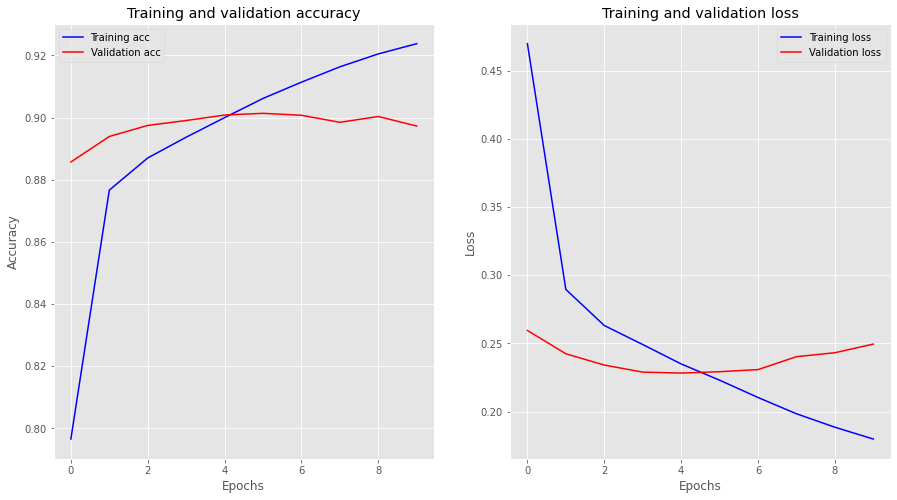

In [31]:
util.plot_accuracy_loss(history, 'CNN_v2')

# **Evaluation**

In [32]:
model = cnn.load_saved_model_v2()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 122, 122)          19449972  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 122, 122)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 122, 128)          62592     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 122, 128)          65664     
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 122, 128)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [33]:
score, acc = model.evaluate(test_converted, target_converted_test, verbose = 2, batch_size = BATCH_SIZE)
print("The loss of this model: %.2f" % (score))
print("The accuracy of this model: %.2f" % (acc))

90/90 - 29s - loss: 0.2317 - acc: 0.8997
The loss of this model: 0.23
The accuracy of this model: 0.90


In [34]:
y_pred = model.predict(test_converted)

Confusion Matrix: 
 [[54223  7806  2548]
 [ 5556 54257  1386]
 [  419   680 56440]]


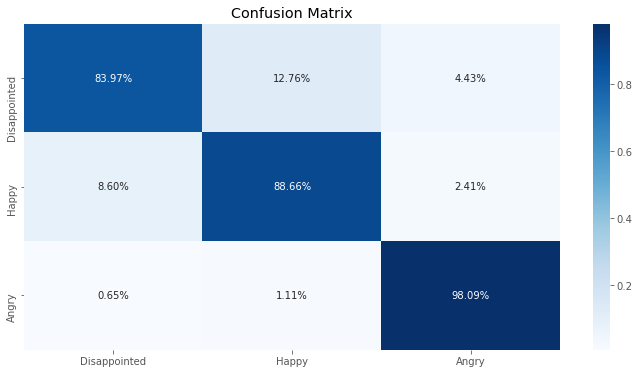

In [35]:
test,pred = util.plot_confusion_matrix(y_pred, target_converted_test, 'CNN_v2')

In [36]:
print("Classification Report: ", classification_report(test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.90      0.84      0.87     64577
           1       0.86      0.89      0.88     61199
           2       0.93      0.98      0.96     57539

    accuracy                           0.90    183315
   macro avg       0.90      0.90      0.90    183315
weighted avg       0.90      0.90      0.90    183315



# **LSTM Model**

In [37]:
# Below method is commented as now for embedding layer some weight matrix is also provided as input.

# lstm = LSTM_Model()
# model = lstm.create_model(embed_dim = 100, lstm_out = 64, 
#                           input_len = train_converted.shape[1], feature = 200000, 
#                           drop_out = 0.8)
# model.summary()

In [38]:
lstm = LSTM_Model()
model = lstm.create_model(embed_dim = max_len, lstm_out = 64, 
                          input_len = train_converted.shape[1], feature = vocab_length, 
                          drop_out = 0.5, embedding_matrix = embedding_matrix)
model.summary()

LSTM Model Initialization...
Model Created Successfully...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 122, 122)          19449972  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 122, 122)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                47872     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 19,498,039
Trainable params: 19,498,039
Non-trainable params: 0
_________________________________________________________________


In [39]:
history = model.fit(train_converted, target_converted_train, epochs = EPOCH, 
                    batch_size= BATCH_SIZE, validation_split=0.2,
                    callbacks=lstm.callbacks)

Epoch 1/10
287/287 [==============================] - 633s 2s/step - loss: 0.7177 - acc: 0.6748 - val_loss: 0.3133 - val_acc: 0.8716

Epoch 00001: val_loss improved from inf to 0.31331, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM/assets
Epoch 2/10
287/287 [==============================] - 640s 2s/step - loss: 0.3762 - acc: 0.8448 - val_loss: 0.2515 - val_acc: 0.8890

Epoch 00002: val_loss improved from 0.31331 to 0.25149, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM/assets
Epoch 3/10
287/287 [==============================] - 639s 2s/step - loss: 0.2919 - acc: 0.8760 - val_loss: 0.2373 - val_acc: 0.8958

Epoch 00003: val_loss improved from 0.25149 to 0.23730, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpo

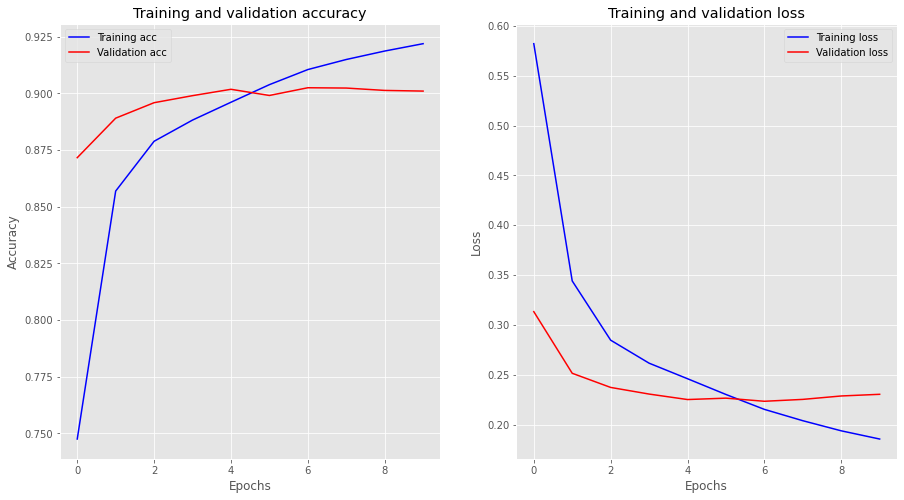

In [40]:
util.plot_accuracy_loss(history, 'LSTM')

# **Evaluation**

In [41]:
model = lstm.load_saved_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 122, 122)          19449972  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 122, 122)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                47872     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 19,498,039
Trainable params: 19,498,039
Non-trainable params: 0
_________________________________________________________________


In [42]:
score, acc = model.evaluate(test_converted, target_converted_test, verbose = 2, batch_size = BATCH_SIZE)
print("The loss of this model: %.2f" % (score))
print("The accuracy of this model: %.2f" % (acc))

90/90 - 36s - loss: 0.2256 - acc: 0.9021
The loss of this model: 0.23
The accuracy of this model: 0.90


In [43]:
y_pred = model.predict(test_converted)

Confusion Matrix: 
 [[54249  7589  2351]
 [ 5525 54610  1513]
 [  424   544 56510]]


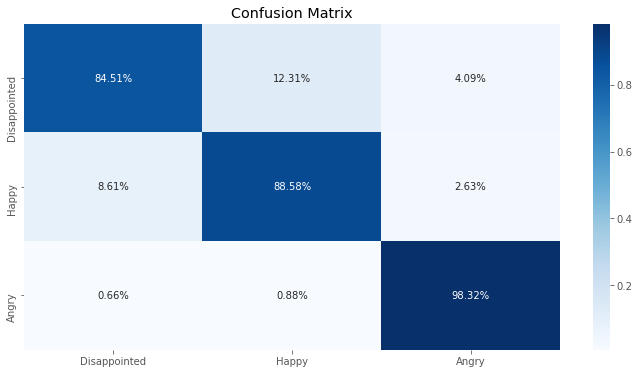

In [44]:
test, pred = util.plot_confusion_matrix(y_pred, target_converted_test, 'LSTM')

In [45]:
print("Classification Report: ", classification_report(test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.90      0.85      0.87     64189
           1       0.87      0.89      0.88     61648
           2       0.94      0.98      0.96     57478

    accuracy                           0.90    183315
   macro avg       0.90      0.90      0.90    183315
weighted avg       0.90      0.90      0.90    183315



# **LSTM_v2**

In [46]:
# Below method is commented as now for embedding layer some weight matrix is also provided as input.

# lstm = LSTM_Model()
# model = lstm.create_model_v2(embed_dim = 100, lstm_out = 64, 
#                           input_len = train_converted.shape[1], feature = 200000, 
#                           drop_out = 0.8)
# model.summary()

In [47]:
lstm = LSTM_Model()
model = lstm.create_model_v2(embed_dim = max_len, lstm_out = 64, 
                          input_len = train_converted.shape[1], feature = vocab_length, 
                          drop_out = 0.5, embedding_matrix = embedding_matrix )
model.summary()

LSTM Model Initialization...
Model Created Successfully...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 122, 122)          19449972  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 122, 122)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 122, 64)           47872     
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 122, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 122, 64)           33024     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_____________________________________________________________

In [48]:
history = model.fit(train_converted, target_converted_train, epochs = EPOCH, 
                    batch_size= BATCH_SIZE, validation_split=0.2,
                    callbacks=lstm.callbacks_v2)

Epoch 1/10
287/287 [==============================] - 1726s 6s/step - loss: 0.8068 - acc: 0.6124 - val_loss: 0.2908 - val_acc: 0.8726

Epoch 00001: val_loss improved from inf to 0.29076, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM_v2/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM_v2/assets
Epoch 2/10
287/287 [==============================] - 1314s 5s/step - loss: 0.3827 - acc: 0.8360 - val_loss: 0.2534 - val_acc: 0.8852

Epoch 00002: val_loss improved from 0.29076 to 0.25342, saving model to /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM_v2/
INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/LSTM_v2/assets
Epoch 3/10
287/287 [==============================] - 1366s 5s/step - loss: 0.3096 - acc: 0.8658 - val_loss: 0.2440 - val_acc: 0.8894

Epoch 00003: val_loss improved from 0.25342 to 0.24401, saving model to /Users/pratiksayanekar/Documents/DL_2

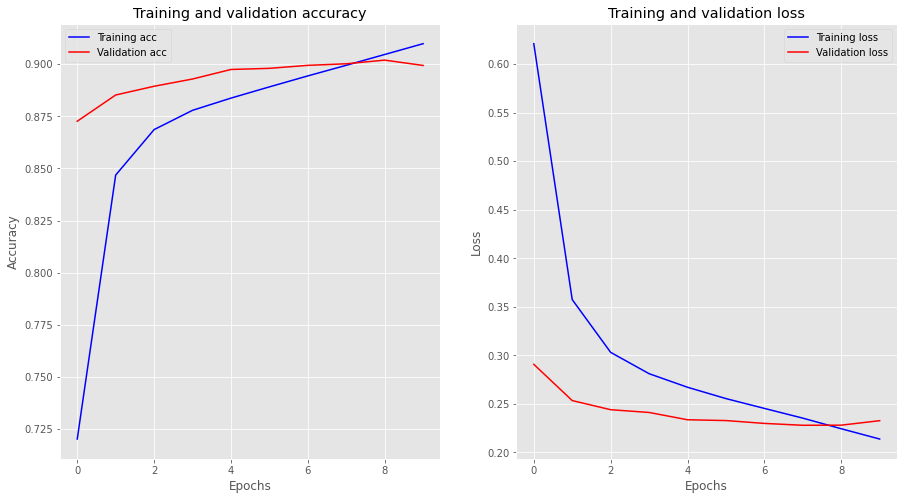

In [49]:
util.plot_accuracy_loss(history, 'LSTM_v2')

# **Evaluation**

In [50]:
model = lstm.load_saved_model_v2()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 122, 122)          19449972  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 122, 122)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 122, 64)           47872     
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 122, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 122, 64)           33024     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [51]:
score, acc = model.evaluate(test_converted, target_converted_test, verbose = 2, batch_size = BATCH_SIZE)
print("The loss of this model: %.2f" % (score))
print("The accuracy of this model: %.2f" % (acc))

90/90 - 61s - loss: 0.2316 - acc: 0.8992
The loss of this model: 0.23
The accuracy of this model: 0.90


In [52]:
y_pred = model.predict(test_converted)

Confusion Matrix: 
 [[55586  9239  2809]
 [ 4094 52607   919]
 [  518   897 56646]]


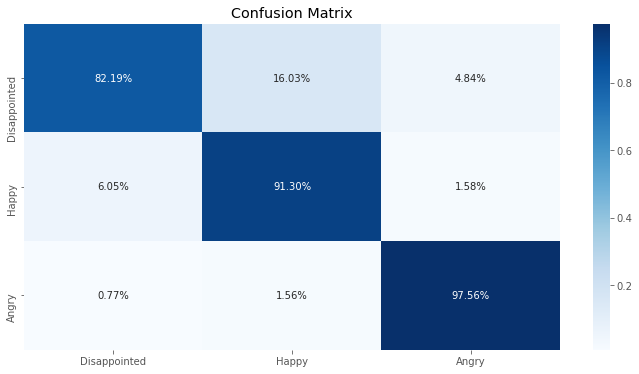

In [53]:
test, pred = util.plot_confusion_matrix(y_pred, target_converted_test, 'LSTM_v2')

In [54]:
print("Classification Report: ", classification_report(test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.92      0.82      0.87     67634
           1       0.84      0.91      0.87     57620
           2       0.94      0.98      0.96     58061

    accuracy                           0.90    183315
   macro avg       0.90      0.90      0.90    183315
weighted avg       0.90      0.90      0.90    183315



# **BiLSTM**

In [55]:
bi_lstm = BiLSTM_Model()
model = bi_lstm.create_model(embed_dim = max_len, lstm_out = 100, input_len = train_converted.shape[1], 
                             feature = vocab_length, drop_out = 0.5, embedding_matrix = embedding_matrix)
model.summary()

BiLSTM Model Initialization...
Model Created Successfully...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 122, 122)          19449972  
_________________________________________________________________
bidirectional (Bidirectional (None, 122, 200)          178400    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 122, 200)          240800    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 118, 100)          100100    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1616      
___________________________________________________________

In [56]:
history = model.fit(train_converted, target_converted_train, batch_size=BATCH_SIZE, epochs=EPOCH,
                    validation_split=0.2, callbacks=bi_lstm.callbacks)

Epoch 1/10
287/287 [==============================] - 4232s 15s/step - loss: 0.4929 - acc: 0.7864 - val_loss: 0.2361 - val_acc: 0.8955


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


Epoch 2/10
287/287 [==============================] - 3708s 13s/step - loss: 0.2451 - acc: 0.8931 - val_loss: 0.2258 - val_acc: 0.9008


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


Epoch 3/10
287/287 [==============================] - 3822s 13s/step - loss: 0.2204 - acc: 0.9046 - val_loss: 0.2204 - val_acc: 0.9037


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


INFO:tensorflow:Assets written to: /Users/pratiksayanekar/Documents/DL_20200161/checkpoints/BiLSTM/assets


Epoch 4/10
287/287 [==============================] - 4579s 16s/step - loss: 0.1974 - acc: 0.9160 - val_loss: 0.2242 - val_acc: 0.9028
Epoch 5/10
287/287 [==============================] - 5066s 18s/step - loss: 0.1693 - acc: 0.9268 - val_loss: 0.2359 - val_acc: 0.9020
Epoch 6/10
287/287 [==============================] - 4494s 16s/step - loss: 0.1537 - acc: 0.9328 - val_loss: 0.2467 - val_acc: 0.9014
Epoch 7/10
287/287 [==============================] - 3787s 13s/step - loss: 0.1464 - acc: 0.9359 - val_loss: 0.2578 - val_acc: 0.9013
Epoch 8/10
287/287 [==============================] - 3527s 12s/step - loss: 0.1411 - acc: 0.9374 - val_loss: 0.2680 - val_acc: 0.9000


# **Evaluation**

In [57]:
model = bi_lstm.load_saved_model()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 122, 122)          19449972  
_________________________________________________________________
bidirectional (Bidirectional (None, 122, 200)          178400    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 122, 200)          240800    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 118, 100)          100100    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                

In [58]:
score, acc = model.evaluate(test_converted, target_converted_test, verbose = 2, batch_size = BATCH_SIZE)
print("The loss of this model: %.2f" % (score))
print("The accuracy of this model: %.2f" % (acc))

90/90 - 224s - loss: 0.2240 - acc: 0.9027
The loss of this model: 0.22
The accuracy of this model: 0.90


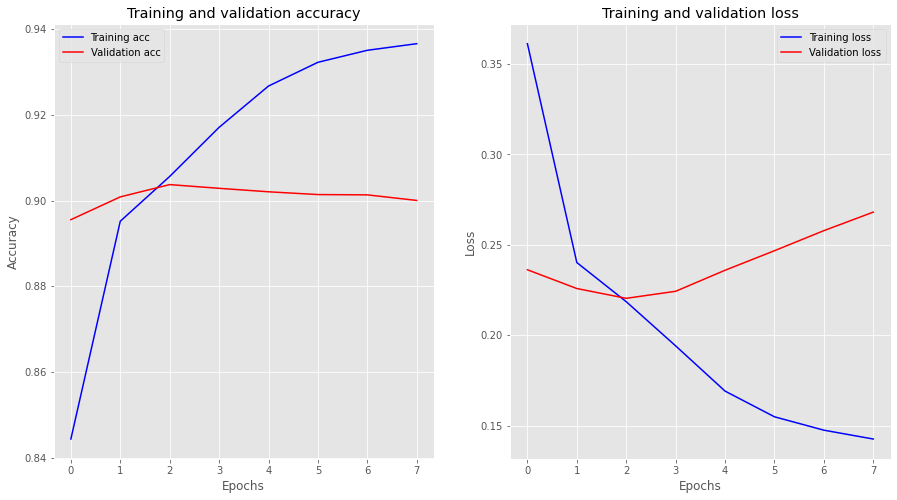

In [59]:
util.plot_accuracy_loss(history, 'BiLSTM')

# **Prediction** 

In [60]:
y_pred = model.predict(test_converted)

Confusion Matrix: 
 [[55597  8812  2693]
 [ 4256 53430  1221]
 [  345   501 56460]]


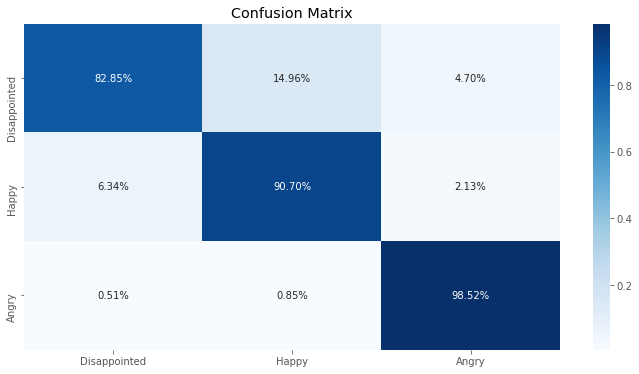

In [61]:
test, pred = util.plot_confusion_matrix(y_pred, target_converted_test, 'BiLSTM')

In [62]:
print("Classification Report: ", classification_report(test, pred))

Classification Report:                precision    recall  f1-score   support

           0       0.92      0.83      0.87     67102
           1       0.85      0.91      0.88     58907
           2       0.94      0.99      0.96     57306

    accuracy                           0.90    183315
   macro avg       0.90      0.91      0.90    183315
weighted avg       0.90      0.90      0.90    183315

